<a href="https://colab.research.google.com/github/Wish245/Fortune-Wheel/blob/main/QlearningRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

# Define the grid size and actions
grid_size = 5
n_actions = 4  # Actions: up, down, left, right

# Initialize the Q-table with zeros
Q_table = np.zeros((grid_size * grid_size, n_actions))

In [2]:
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor for future rewards
epsilon = 0.1  # Exploration rate for epsilon-greedy policy

In [3]:
# Reward matrix for the grid environment
rewards = np.full((grid_size * grid_size,), -1)  # -1 for every state
rewards[24] = 10  # Goal state
rewards[12] = -10  # Pitfall state

In [4]:
def epsilon_greedy_action(Q_table, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.randint(0, n_actions)  # Explore: random action
    else:
        return np.argmax(Q_table[state])  # Exploit: action with highest Q-value

In [5]:
for episode in range(1000):
    state = np.random.randint(0, grid_size * grid_size)  # Start in a random state
    done = False
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, grid_size * grid_size)  # Simulated next state
        reward = rewards[next_state]

        # Update Q-value using Bellman equation
        Q_table[state, action] = Q_table[state, action] + alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])

        state = next_state
        if next_state == 24 or next_state == 12:
            done = True

In [6]:
import tensorflow as tf

# Define the policy network
n_states = grid_size * grid_size  # Number of states in the grid
n_actions = 4  # Up, down, left, right

model = tf.keras.Sequential([
    tf.keras.layers.Dense(24, activation='relu', input_shape=(n_states,)),
    tf.keras.layers.Dense(n_actions, activation='softmax')  # Output action probabilities
])

# Optimizer for policy network updates
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def get_action(state):
    state_input = tf.one_hot(state, n_states)  # One-hot encoding for state
    action_probs = model(state_input[np.newaxis, :])
    return np.random.choice(n_actions, p=action_probs.numpy()[0])

In [8]:
# Simulation loop
states = []
actions = []
episode_rewards = []

for episode in range(1000):
    state = np.random.randint(0, n_states)  # Start in a random state
    done = False
    while not done:
        action = get_action(state)  # Use the provided function
        next_state = np.random.randint(0, n_states)  # Simulated next state
        reward = rewards[next_state]

        # Store the state-action-reward trajectory
        states.append(state)
        actions.append(action)
        episode_rewards.append(reward)

        state = next_state
        if next_state in {24, 12}:
            done = True

In [9]:
def compute_cumulative_rewards(rewards, gamma=0.99):
    cumulative_rewards = np.zeros_like(rewards)
    running_add = 0
    for t in reversed(range(len(rewards))):
        running_add = running_add * gamma + rewards[t]
        cumulative_rewards[t] = running_add
    return cumulative_rewards

In [10]:
def update_policy(states, actions, rewards):
    cumulative_rewards = compute_cumulative_rewards(rewards)

    with tf.GradientTape() as tape:
        state_inputs = tf.one_hot(states, n_states)  # Convert states to one-hot encoding
        action_probs = model(state_inputs)
        action_masks = tf.one_hot(actions, n_actions)  # Mask for selected actions
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs), axis=1)

        # Policy loss is the negative log-probability of the action times the cumulative reward
        loss = -tf.reduce_mean(log_probs * cumulative_rewards)

    # Apply gradients to update the policy network
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

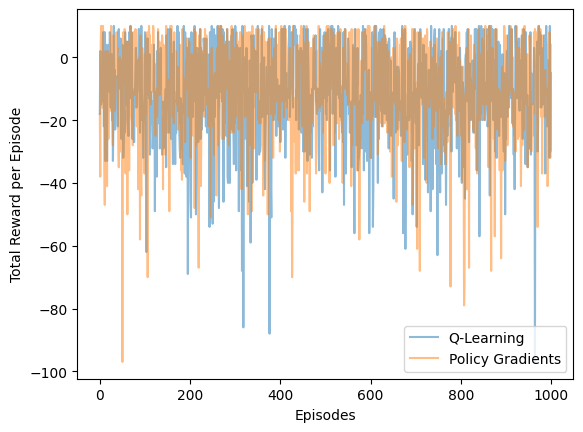

In [12]:
import matplotlib.pyplot as plt

# Note: To make this plot work, you must track rewards in your training loops.
# Below is a corrected version assuming you collect episode rewards.

# 1. Re-run Q-Learning with tracking
rewards_q_learning = []
Q_table = np.zeros((grid_size * grid_size, n_actions))
for episode in range(1000):
    state = np.random.randint(0, grid_size * grid_size)
    done = False
    total_reward = 0
    while not done:
        action = epsilon_greedy_action(Q_table, state, epsilon)
        next_state = np.random.randint(0, grid_size * grid_size)
        reward = rewards[next_state]
        total_reward += reward
        Q_table[state, action] += alpha * (reward + gamma * np.max(Q_table[next_state]) - Q_table[state, action])
        state = next_state
        if next_state in [24, 12]: done = True
    rewards_q_learning.append(total_reward)

# 2. Re-run Policy Gradient with tracking
rewards_policy_gradients = []
for episode in range(1000):
    state = np.random.randint(0, n_states)
    done = False
    ep_states, ep_actions, ep_rewards = [], [], []
    while not done:
        action = get_action(state)
        next_state = np.random.randint(0, n_states)
        reward = rewards[next_state]
        ep_states.append(state)
        ep_actions.append(action)
        ep_rewards.append(reward)
        state = next_state
        if next_state in [24, 12]: done = True
    update_policy(ep_states, ep_actions, ep_rewards)
    rewards_policy_gradients.append(sum(ep_rewards))

# 3. Plotting
plt.plot(rewards_q_learning, label='Q-Learning', alpha=0.5)
plt.plot(rewards_policy_gradients, label='Policy Gradients', alpha=0.5)
plt.xlabel('Episodes')
plt.ylabel('Total Reward per Episode')
plt.legend()
plt.show()